# Cost-Benefit Analysis of Different Gas Price Selection Techniques

We perform a cost-benefit analysis of two different gas price selection techniques: *recommended* and *rand1*.
- *recommended*: 60th percentile of the last 20 blocks (note: this is the default recommended gas price given by GETH)
- *rand1*: the gas price from a randomly selected transaction from the most recently mined block, optionally bounded by *recommended*

### Airnode simulation
The data we use comes from a simulation of Airnode using historical transaction data.

Modeling Airnode behavior:
1. Airnode wakes up every minute
    * We assume it always has requests, and thus must make a transaction every minute.  
2. It checks the most recently mined block.
3. It randomly selects a txn from that block.
4. The gas price of that txn is selected as the price of Airnode's current txn. To mitigate against extreme values, we bound this by $[r, 2r]$, where *r* is the recommended gas price given by *recommended*.

See `airnode_sim` in `./_airnode_sim_utils.py` for how this is implemented.

In [1]:
import datetime
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import _airnode_sim_utils

API3_PURPLE = '#7963B2'
API3_EMERALD = '#7CE3CB'

to_date_str = lambda ts: datetime.datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')

## Get historical data

In [2]:
file_patterns = [
    '../gas_prices_2020-03-11_2020-03-13_100%-sampling*',
    '../gas_prices_2020-03-13_2020-03-14_100%-sampling*'
]

df = _airnode_sim_utils.load_data(file_patterns)
df

340 total files.


,blockNum,timeStamp,txnID,gasPrice
0,9646854,1583884773,0x1eb4d0a5e7702cf65d4a2e49743989cfc39a005d7d70...,40.000000
1,9646854,1583884773,0x1906edf9ba5a06ad9870910892b4a34bc1d2fe3885ef...,10.000000
2,9646854,1583884773,0xd9867d0d23048a0a7afa255c411597aac87dde6b7c58...,10.000000
3,9646854,1583884773,0x0ce33d9fd0a59f3b9d8fe16c51c24bd5f1eea6b9f479...,10.000000
4,9646854,1583884773,0x6e27c8fe7fa22d438e635e7085d0f971ee4e0438638d...,12.000000
...,...,...,...,...
2311300,9666211,1584143961,0xf4a8a769fa52ff5e2e5de24e8fa0e064d4169220140a...,10.000000
2311301,9666211,1584143961,0x671c031fc4901d4e8af3ef0bd39183f44e733350170a...,10.000001
2311302,9666211,1584143961,0x5ac5b6b2f8d332bac977bd4234f48865af212f4c5c2f...,12.000000
2311303,9666211,1584143961,0x9101913acca25b62dfe36ec2ec71600be16b44c3df78...,10.000000


In [3]:
start_ts = df.iloc[0]['timeStamp']
end_ts = df.iloc[-1]['timeStamp']

print("PRECISE DATE RANGE")
print(f"Start:\t{to_date_str(start_ts)}")
print(f"End:\t{to_date_str(end_ts)}")

PRECISE DATE RANGE
Start:	2020-03-10 23:59:33
End:	2020-03-13 23:59:21


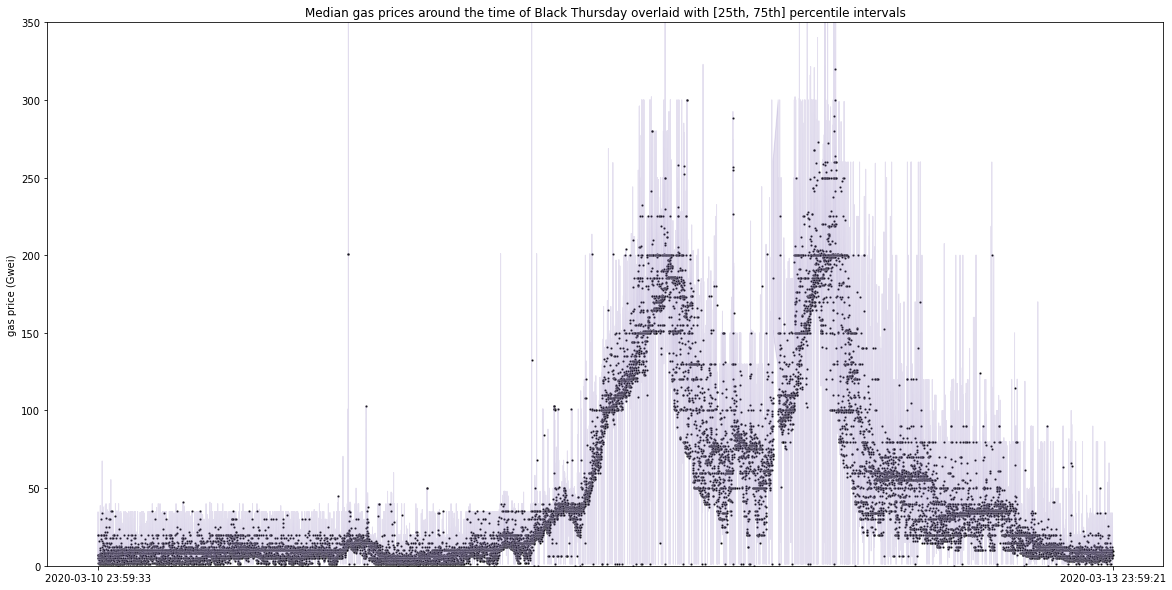

In [4]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

df_agg = df.groupby('blockNum')['gasPrice'].aggregate(['median', 'mean', 'std', percentile(25), percentile(75)])
df_agg = df_agg.reset_index()

# overlay individual median points with [25, 75] percentile range
lower_bound = np.array(df_agg['percentile_25'])
upper_bound = np.array(df_agg['percentile_75'])

_, ax = plt.subplots(1, 1, figsize=(20,10))

g = sns.scatterplot(x="blockNum", y="median", data=df_agg, s=5, color="black")
plt.fill_between(df_agg['blockNum'], lower_bound, upper_bound, alpha=.2, color=API3_PURPLE);
plt.ylim(0, 350);

g.set(
    xlabel='',
    ylabel='gas price (Gwei)',
    xticks=[df_agg['blockNum'].iloc[0], df_agg['blockNum'].iloc[-1]],
    xticklabels=[to_date_str(start_ts), to_date_str(end_ts)]
)

g.set_title(f'Median gas prices around the time of Black Thursday overlaid with [25th, 75th] percentile intervals');

## Run Airnode simulation

In [5]:
'''
We randomly select when the Airnode starts running.
To ensure enough historical blocks to compute recommended gas price, 
we start approx. 5 minutes after our historical data starts.
Similar reasoning for end time.
'''

airnode_start_ts = df.iloc[0]['timeStamp'] + random.randint(5 * 60, 6 * 60)
print(f'Airnode sim start time: {to_date_str(airnode_start_ts)}')

airnode_end_ts = df.iloc[-1]['timeStamp'] - random.randint(5 * 60, 6 * 60)
print(f'Airnode sim end time: {to_date_str(airnode_end_ts)}')

Airnode sim start time: 2020-03-11 00:04:48
Airnode sim end time: 2020-03-13 23:53:23


In [6]:
airnode_wake_up_times = range(airnode_start_ts, airnode_end_ts, 60)

In [7]:
df_result_reco = _airnode_sim_utils.airnode_sim(df, airnode_wake_up_times)

In [8]:
df_result_rand = _airnode_sim_utils.airnode_sim(df, airnode_wake_up_times, gas_price_selection='rand1')

In [10]:
# postprocess
# account for txns that don't get confirmed before Airnode wakes up again
def _postprocess(df):
    # NOTE: must do in reverse, omitted long explanation
    for i in range(df.shape[0] - 1, -1, -1):
        row = df.iloc[i]
        if np.isnan(row['confirmation_time_block_num']):
            # add conf time of next "wake up"
            conf_blocks = df.iloc[i + 1]['confirmation_time_block_num']
            conf_secs = 60 + df.iloc[i + 1]['confirmation_time_seconds']
            
            df.at[row.name, 'confirmation_time_block_num'] = conf_blocks
            df.at[row.name, 'confirmation_time_seconds'] = conf_secs

    return df

df_result_rand = _postprocess(df_result_rand)
df_result_reco = _postprocess(df_result_reco)

In [11]:
n = df_result_rand.shape[0]

df_result_rand['method'] = pd.Series(['rand'] * n, index=df_result_rand.index)
df_result_reco['method'] = pd.Series(['reco'] * n, index=df_result_reco.index)

df_result = pd.concat([df_result_rand, df_result_reco])

## Results & Conclusion

In [12]:
grouped = df_result.groupby('method').aggregate(['mean', 'std'])
grouped

wakeup_ts                gasPrice               mined?            \
              mean          std       mean        std      mean       std   
method                                                                      
rand    1584014328  74642.72905  57.925708  65.903674  0.977489  0.148356   
reco    1584014328  74642.72905  48.331330  54.516134  0.964261  0.185661   

       confirmation_time_block_num           confirmation_time_seconds  \
                              mean       std                      mean   
method                                                                   
rand                      1.041309  0.234376                 19.286145   
reco                      1.090740  0.368666                 20.249478   

                   
              std  
method             
rand    76.238968  
reco    76.473754

In [13]:
inc = lambda metric: (grouped[metric].loc['rand']['mean'] - grouped[metric].loc['reco']['mean']) / grouped[metric].loc['reco']['mean']

When comparing *recommended* to *rand*:

In [14]:
print(f"Gas price increase:\t\t{100 * inc('gasPrice'):.1f}%")
print(f"Confirmation block decrease:\t{100 * inc('confirmation_time_block_num'):.1f}%")
print(f"Confirmation time decrease:\t{100 * inc('confirmation_time_seconds'):.1f}%")

Gas price increase:		19.9%
Confirmation block decrease:	-4.5%
Confirmation time decrease:	-4.8%


**Conclusion**: by using *rand1* over *recommended* we see an increase of ~20% in gas price and a decrease of ~5% in confirmation time.

## Appendix: various visualizations of the different between *rand1* and *recommended*

### Visualizing difference in gas prices

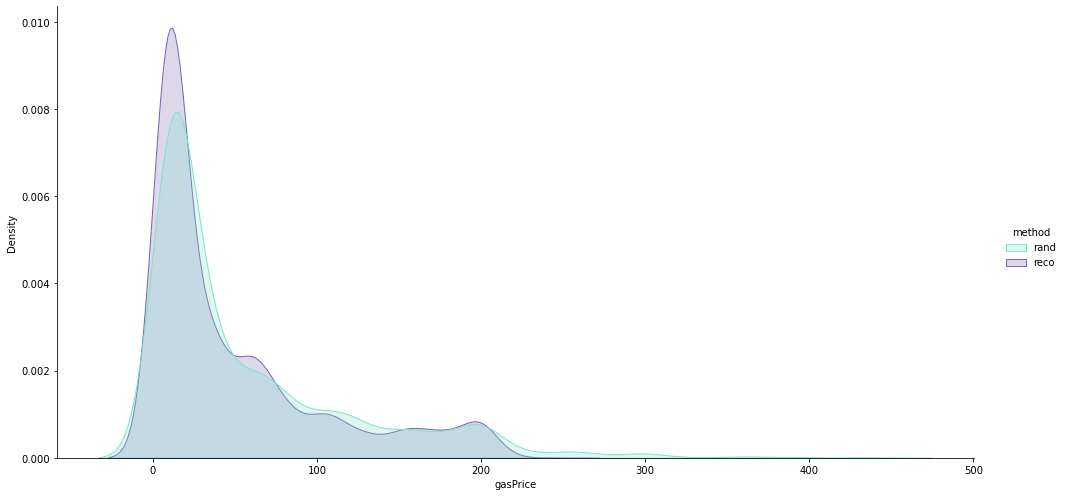

In [15]:
g = sns.displot(df_result, x="gasPrice", hue="method", kind="kde", fill=True, palette=[API3_EMERALD, API3_PURPLE], height=7, aspect=2)

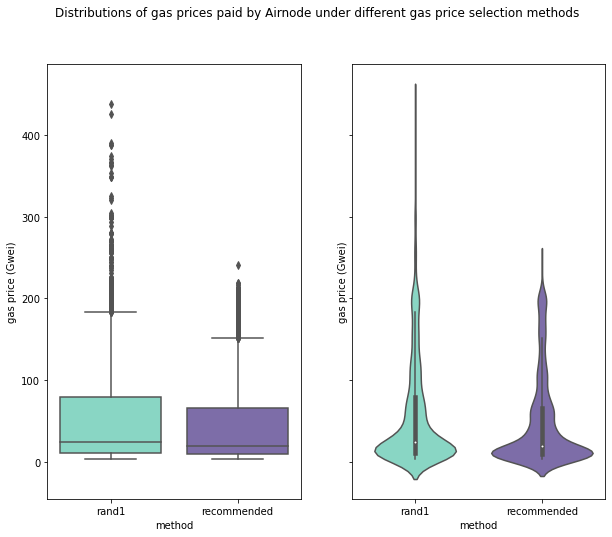

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 8))
fig.suptitle('Distributions of gas prices paid by Airnode under different gas price selection methods')
#ax1.plot(x, y)
#ax2.plot(x, -y)

g1 = sns.boxplot(x="method", y="gasPrice", data=df_result, ax=axs[0], palette=[API3_EMERALD, API3_PURPLE])
g2 = sns.violinplot(x="method", y="gasPrice", data=df_result, ax=axs[1], palette=[API3_EMERALD, API3_PURPLE])

for g in [g1, g2]:
    g.set(
        xlabel='method',
        ylabel='gas price (Gwei)',
        xticklabels=['rand1', 'recommended']
    );

### Visualizing difference in confirmation times (measured in blocks)

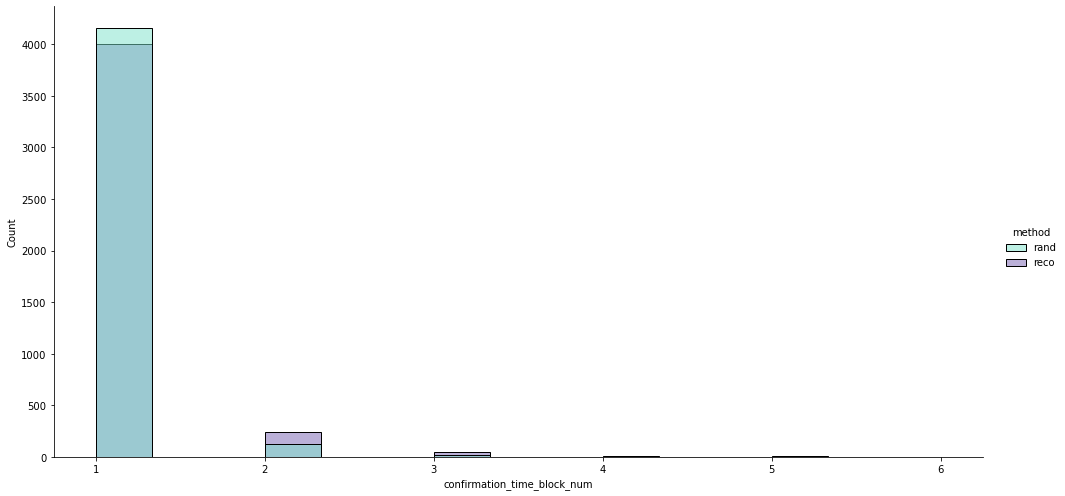

In [17]:
g = sns.displot(df_result, x="confirmation_time_block_num", hue="method", fill=True, palette=[API3_EMERALD, API3_PURPLE], height=7, aspect=2)

zoomed in ...


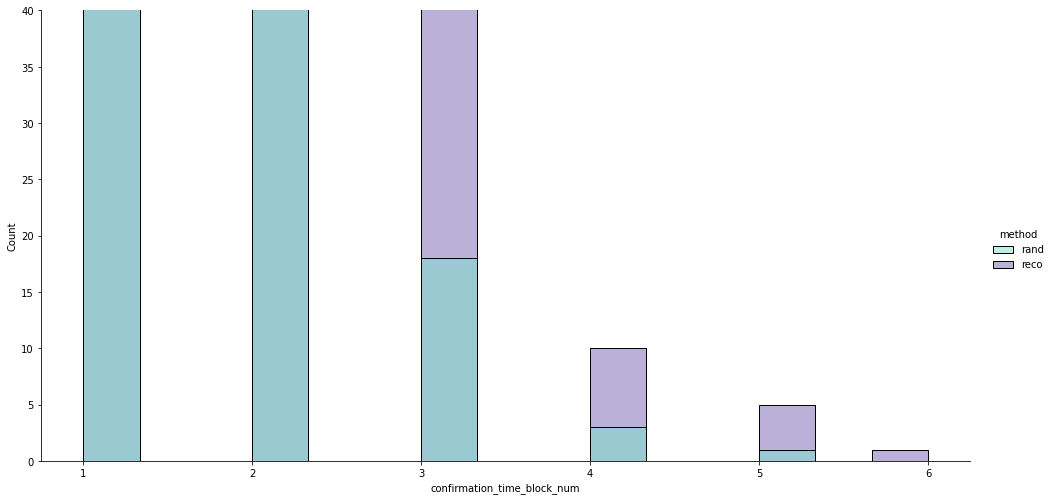

In [18]:
g = sns.displot(df_result, x="confirmation_time_block_num", hue="method", fill=True, palette=[API3_EMERALD, API3_PURPLE], height=7, aspect=2)
g.set(ylim=(0, 40));
print("zoomed in ...")

### Visualizing difference in confirmation times (measured in seconds)

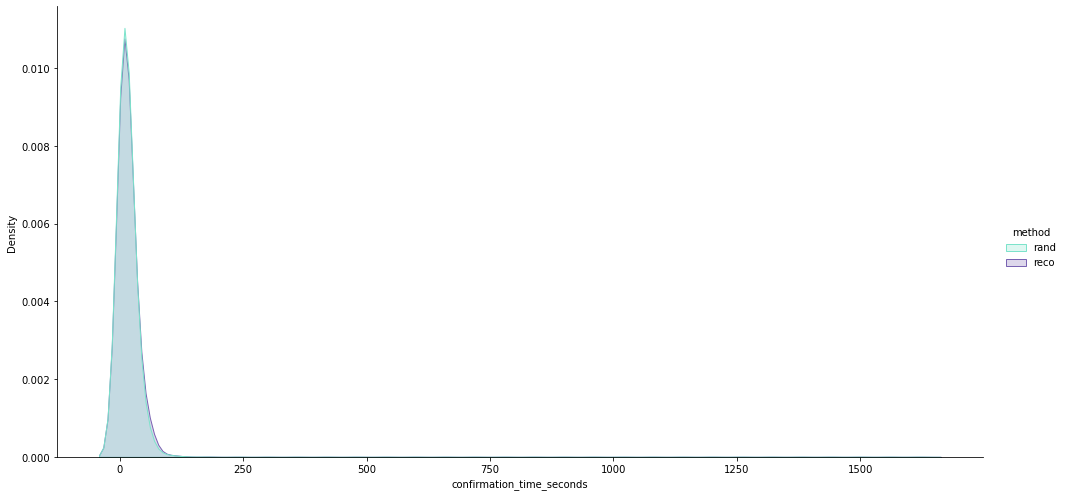

In [19]:
g = sns.displot(df_result, x="confirmation_time_seconds", hue="method", kind="kde", fill=True, palette=[API3_EMERALD, API3_PURPLE], height=7, aspect=2)

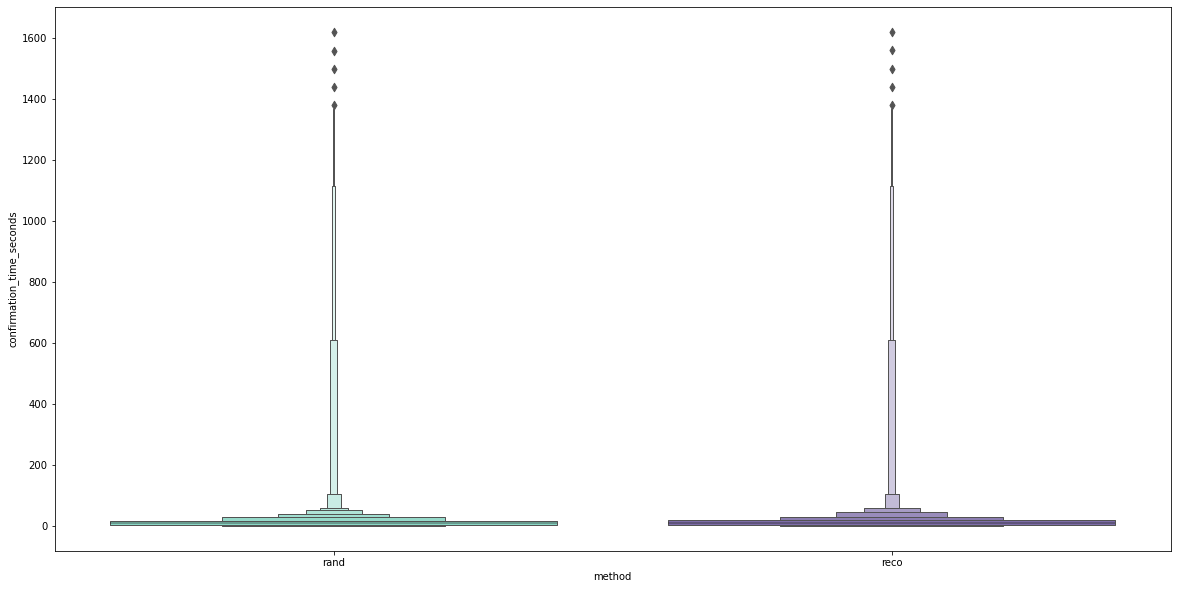

In [20]:
_, ax = plt.subplots(1, 1, figsize=(20,10))
sns.boxenplot(x="method", y="confirmation_time_seconds", data=df_result, palette=[API3_EMERALD, API3_PURPLE]);

zoomed in ...


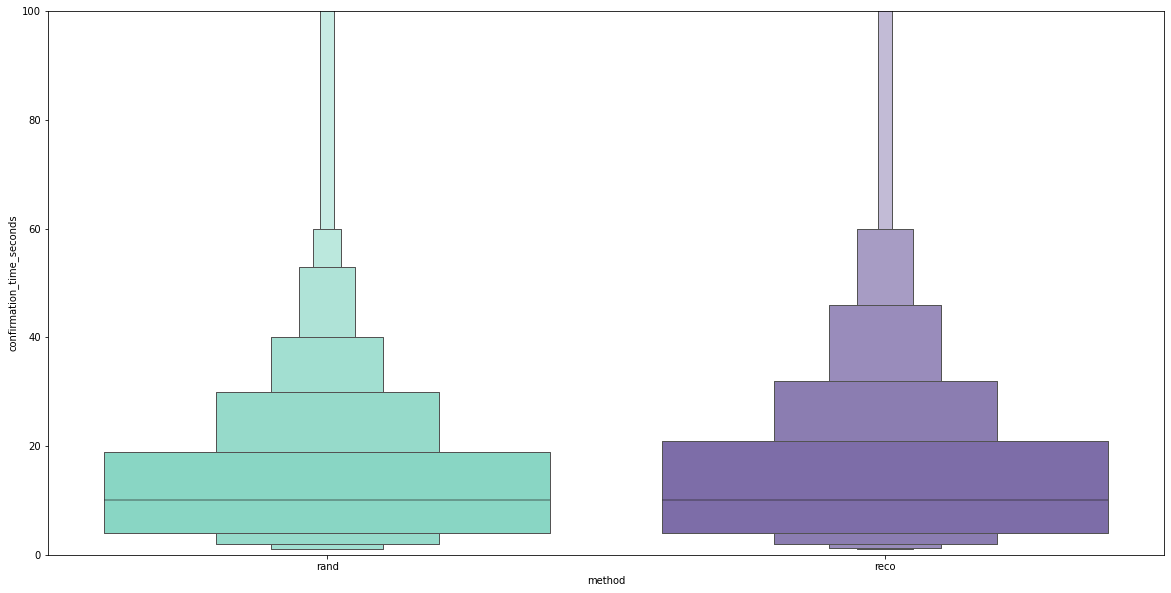

In [21]:
print('zoomed in ...')
_, ax = plt.subplots(1, 1, figsize=(20,10))
g = sns.boxenplot(x="method", y="confirmation_time_seconds", data=df_result, palette=[API3_EMERALD, API3_PURPLE]);
g.set(ylim=(0, 100));